<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling of Israeli Movies Synopses - Digital Humanities Mini Project

In this project, we explore the hidden structures of ±1000 IMDB movies, originated in Israel, based on their synopses content.
Summary of the machine learning flow:

* **Problem statement:**	Unsupervised classification on given movie synopses by NLP
* **Data preprocessing:**	Tokenization and stemming
* **Model training:**	Latent Dirichlet Allocation (LDA) for topic modeling
* **Evaluation:**	main question: Have movie topics, in the Israeli Movie industry, changed over the years?
* **Result:**	Visualiztion of words in each topic, their intertopic distance and the classification of topic to years

The input dataset contains synopses for [IMDB's Feature Films originated in Israel](https://www.imdb.com/search/title/?title_type=feature&countries=il&start=1&ref_=adv_nxt). Each synopsis, or document, is encoded by vector denoting the weight of tokens, which can represent a word or word collection formulated by Bag-of-words model and N-gram model. The weight of each token is determined by the frequency of the term. In the feature engineering stage, each document can be vectorized by the distribution of words.
We adopt Latent Dirichlet Allocation (LDA) to include semantic relation and extract hidden topics.



## Part 1: Load Data from IMDb

**Attention: This stage should run only once to collect data!!! Once the dataset is ready, we can use it by uploading it in the relevant place**

In [ ]:
!pip install cinemagoer
!pip install wikipedia

import re
import pandas as pd
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import numpy as np
from imdb import Cinemagoer
import time
import tqdm

In [ ]:
ia = Cinemagoer()
data = []

In [ ]:
def getMovieId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

In [ ]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
  i = 0
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)

    # Movie id
    id = getMovieId(image)
        
    # Movie release year
    year = getReleaseYear(header)

    # Movie Synopsys
    synopsis = getSynopsisFromImdb(id)

    # Genre
    genre = getGenre(muted_text)

    data.append({'IMDb_id': id, 'Title': movie_title, 'Year': year, 'Genre': genre, 'Synopsis': synopsis})

In [ ]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 2

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

In [ ]:
df = pd.DataFrame(data)
# save data
df.to_csv('israel_originated_movies_imdb.csv')

### Load Synopses from Wikipedia

In [ ]:
import wikipedia

wiki_title = []
wiki_plot = []
wiki_summary = []

In [ ]:
def find_title_on_wikipedia(title, year):
    search_results = wikipedia.search(title, results=20)
    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    return title

def add_wikipedia(data):
  for i in range (len(data)):
    imdb_title = data['English Title'][i]
    year = data['Year'][i]
    title, page, summary = np.nan, np.nan, np.nan

    title = find_title_on_wikipedia(imdb_title, year)
    
    if title != None or title != np.nan:
      page = wikipedia.WikipediaPage(title = title)

      if page != None or page != np.nan:
        summary = page.summary

    wiki_title.append(title)
    wiki_summary.append(summary)


In [ ]:
data = pd.read_csv('israel_originated_movies_imdb_cleared.csv')
add_wikipedia(data)
data['Wiki Title'] = wiki_title
data['Wiki Summary'] = wiki_summary

In [ ]:
data.to_csv('israel_originated_movies_imdb_with_wiki.csv')
data

## Part 2: Text Preprocessing

In [ ]:
!pip install pyLDAvis
!pip install swifter

from pydoc import synopsis
from dateutil.parser import parse
import concurrent.futures
import json
import re
import glob
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

clean year representation. Records with null values removed as well

In [3]:
cleared_data = pd.read_csv('israel_originated_movies_imdb.csv').dropna()
cleared_data = cleared_data[cleared_data.Year != '(III']
cleared_data = cleared_data[cleared_data.Year != '(LX']
cleared_data = cleared_data[cleared_data.Year != '(II']
cleared_data = cleared_data[cleared_data.Year != '(I']
cleared_data = cleared_data[cleared_data.Year != '(V']
cleared_data = cleared_data[cleared_data.Year != '(VII']
cleared_data = cleared_data[cleared_data.Year != '(VI']
cleared_data = cleared_data[cleared_data.Year != '(X']
cleared_data = cleared_data[cleared_data.Year != 'XXXI']

cleared_data.to_csv('ready_for_topic_modeling.csv', index=False)

cleared_data

,Unnamed: 0,Title,English Title,Year,Genre,Synopsis,IMDb id
0,0,The Frog Prince,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...,95182
1,1,Knock Knock,Alex Is Lovesick,2015,"Drama, Thriller",This romantic comedy takes place in Israel dur...,3605418
2,2,Footnote,Footnote,2011,"Comedy, Drama",Eliezer and Uriel Shkolnik are father and son ...,1445520
3,3,Alex Holeh Ahavah,Shiva,1986,"Comedy, Drama, Romance","When one of the brothers (Ohayn) dies, all the...",133351
4,4,Shiva,Knock Knock,2008,"Drama, Romance",A devoted father helps two stranded young wome...,1260396
...,...,...,...,...,...,...,...
1455,1455,Who Are You to Me?,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider...",1826755
1458,1458,The Investigation Must Go On,Clay - IMDb,2000,"Crime, Drama","Rachel, a newlywed orthodox Jewish woman, can'...",258635
1461,1461,Shalom (Wayfarer's Prayer),Shalom (Wayfarer's Prayer),1973,Drama,"Shalom, a young Israeli at the outset of his l...",152387
1465,1465,Halav,Halav,2021,"Crime, Mystery, Thriller",'Milk' is a psychological thriller telling the...,9800124


 Tokenize and Clean quotes, new line, verbs etc.

In [4]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [5]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv')

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))

---Doing pre-processing for Synopsis..
Initial pre-processing..


Build the Bigram, Trigram Models and Lemmatize

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['israeli','israelis', 'film', 'films', 'story', 'movie', 'movies', 'year'])
print ('We use {} stop-words from nltk library.'.format(str(len(stopwords))))
print ('First ten stop-words are {}'.format(stopwords[:10]))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

We use 187 stop-words from nltk library.
First ten stop-words are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [7]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1054 [00:00<?, ?it/s]

,Unnamed: 0,Title,English Title,Year,Genre,Synopsis,IMDb id,Synopsis_lemmatized,Synopsis_preprocessed
0,0,The Frog Prince,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...,95182,"[children, musical, grimms, fairy, tale, frog,...",children musical grimms fairy tale frog king y...
1,1,Knock Knock,Alex Is Lovesick,2015,"Drama, Thriller",This romantic comedy takes place in Israel dur...,3605418,"[romantic, comedy, place, austerity, period, o...",romantic comedy place austerity period old bar...
2,2,Footnote,Footnote,2011,"Comedy, Drama",Eliezer and Uriel Shkolnik are father and son ...,1445520,"[uriel, shkolnik, son, rival, professor, talmu...",uriel shkolnik son rival professor talmudic st...
3,3,Alex Holeh Ahavah,Shiva,1986,"Comedy, Drama, Romance","When one of the brothers (Ohayn) dies, all the...",133351,"[whole, family, shiva, jewish, tradition, fami...",whole family shiva jewish tradition family day...
4,4,Shiva,Knock Knock,2008,"Drama, Romance",A devoted father helps two stranded young wome...,1260396,"[father, strand, young, woman, door, kind, ges...",father strand young woman door kind gesture da...
...,...,...,...,...,...,...,...,...,...
1049,1455,Who Are You to Me?,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider...",1826755,"[encounter, people, outsider, normal, society,...",encounter people outsider normal society painf...
1050,1458,The Investigation Must Go On,Clay - IMDb,2000,"Crime, Drama","Rachel, a newlywed orthodox Jewish woman, can'...",258635,"[jewish, woman, figure, husband, sex, homosexu...",jewish woman figure husband sex homosexual rel...
1051,1461,Shalom (Wayfarer's Prayer),Shalom (Wayfarer's Prayer),1973,Drama,"Shalom, a young Israeli at the outset of his l...",152387,"[young, outset, life, bourgeois, family, tel_a...",young outset life bourgeois family tel_aviv pa...
1052,1465,Halav,Halav,2021,"Crime, Mystery, Thriller",'Milk' is a psychological thriller telling the...,9800124,"[milk, psychological, thriller, scientist, com...",milk psychological thriller scientist company ...


#### Most common words


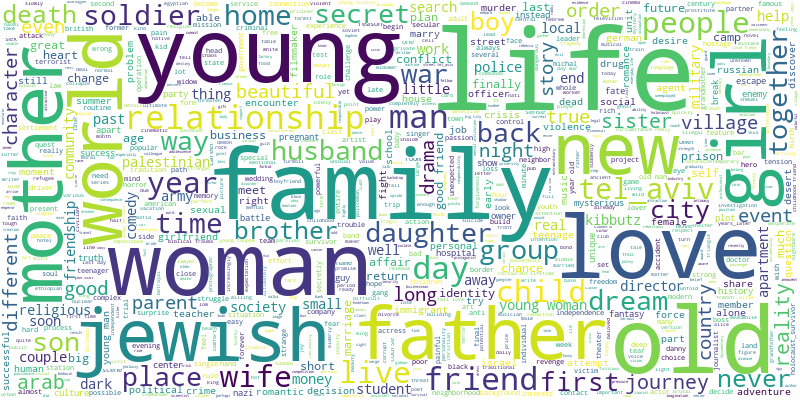

In [8]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Part 3: Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [9]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [10]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

## Part 4: Evaluation

In this section we will try to answer the question
> **Have movie topics, in the Israeli Movie industry, changed over the years?**

In [11]:
lda_model.print_topics()

[(0,
  '0.016*"woman" + 0.014*"life" + 0.009*"way" + 0.008*"family" + 0.008*"old" + 0.007*"people" + 0.007*"together" + 0.007*"child" + 0.006*"ethiopian" + 0.006*"jewish"'),
 (1,
  '0.013*"mother" + 0.012*"young" + 0.012*"father" + 0.011*"life" + 0.010*"family" + 0.009*"man" + 0.007*"old" + 0.006*"death" + 0.006*"group" + 0.006*"friend"'),
 (2,
  '0.016*"life" + 0.014*"woman" + 0.014*"love" + 0.013*"old" + 0.011*"young" + 0.010*"friend" + 0.008*"man" + 0.007*"daughter" + 0.006*"dream" + 0.006*"relationship"'),
 (3,
  '0.013*"family" + 0.009*"s" + 0.008*"drama" + 0.008*"immigrant" + 0.006*"life" + 0.006*"new" + 0.006*"camera" + 0.006*"hour" + 0.006*"young" + 0.006*"pain"'),
 (4,
  '0.016*"life" + 0.012*"love" + 0.010*"old" + 0.009*"woman" + 0.009*"soldier" + 0.008*"couple" + 0.008*"jewish" + 0.007*"kibbutz" + 0.007*"relationship" + 0.006*"world"'),
 (5,
  '0.018*"family" + 0.012*"village" + 0.011*"back" + 0.010*"friend" + 0.010*"year" + 0.009*"girl" + 0.009*"love" + 0.007*"young" + 0.00

Assign Dominant Topic to each record

In [12]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

del ready_data['i']
ready_data = ready_data.sort_values(by=[f'{source}_topic'])
ready_data

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

,Unnamed: 0,Title,English Title,Year,Genre,Synopsis,IMDb id,Synopsis_lemmatized,Synopsis_preprocessed,Synopsis_topic
528,572,Emile's Girlfriend,Emile's Girlfriend,2006,Drama,"In Tel Aviv, Yoav receives a visit from Delphi...",1046926,"[receive, girlfriend, emile, boyfriend, day, t...",receive girlfriend emile boyfriend day togethe...,0
102,104,Surrogate,Surrogate,2008,Drama,Eli is a 32 year old man who has problems with...,1407081,"[man, problem, relationship, woman, surrogate,...",man problem relationship woman surrogate alter...,0
958,1202,First Love,First Love,1982,Drama,The ex-lover of a middle class woman appears o...,133342,"[middle, class, woman, birthday, year, mother,...",middle class woman birthday year mother daught...,0
713,805,Green,Wasserman - The Rain Man,1983,Drama,Seventy-three year old Wasserman swore never t...,133817,"[old, wasserman, never, holocaust, unwilling, ...",old wasserman never holocaust unwilling dire s...,0
719,814,Planet Blue,Without Home,1995,"Adventure, Comedy, Drama",This is the story of a small band of Jews who ...,112699,"[small, band, foot, naomi, damari, jewish, wom...",small band foot naomi damari jewish woman chil...,0
...,...,...,...,...,...,...,...,...,...,...
718,813,Obsession,Obsession,2011,Drama,"The 1960's, a Sephardic old neighborhood in Je...",1969118,"[sephardic, old, neighborhood, timid, silent, ...",sephardic old neighborhood timid silent family...,9
351,361,My Michael,The Rule of Law,1974,Drama,A new age of terrorism is taking place in the ...,73383,"[new, age, terrorism, place, frame, innocent, ...",new age terrorism place frame innocent america...,9
219,222,Eminent Domain,Eminent Domain,1990,"Drama, Thriller",A high-ranking Polish politburo member is bani...,101809,"[high, rank, set, solidarity, event]",high rank set solidarity event,9
339,349,The Summer of Aviya,Halfon Hill Doesn't Answer,1988,"Biography, Drama",Swindler Sergio Konstanza owes money to Mr. Ha...,95433,"[swindler, sergio, konstanza, money, unit, eye...",swindler sergio konstanza money unit eye daugh...,9


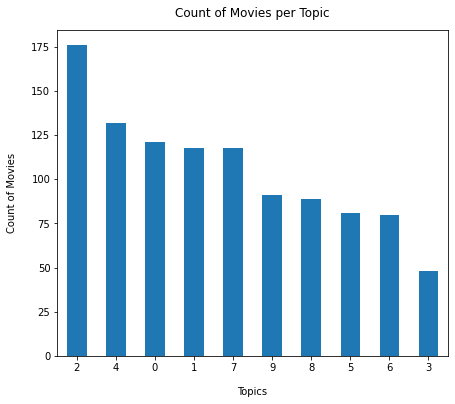

In [13]:
ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

**The average years of the movies, classified according to the Topics**

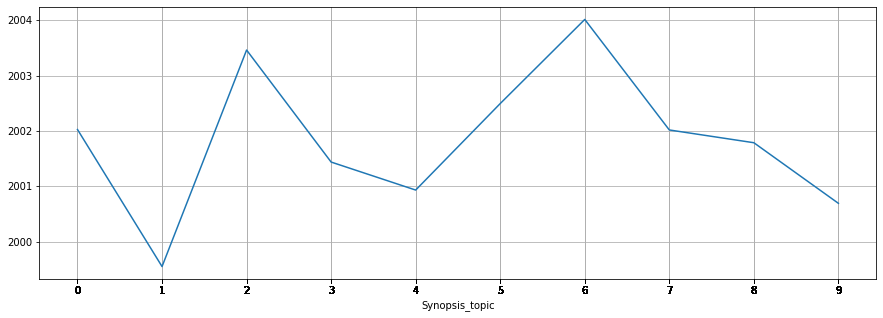

In [15]:
movie_avg = ready_data.copy()
movie_avg.groupby(f'{source}_topic')['Year'].mean().plot(x=f'{source}_topic', xticks=movie_avg[f'{source}_topic'] ,figsize=(15,5), grid=True)

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

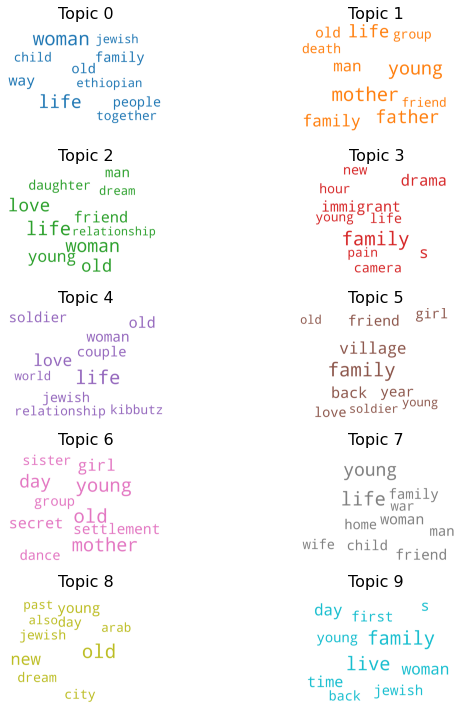

In [16]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.046284 -0.069082       1        1  17.534420
0     -0.087979 -0.022020       2        1  11.806980
7     -0.008628 -0.075561       3        1  11.329346
1     -0.042293 -0.086308       4        1  11.178769
4     -0.005792  0.009017       5        1  11.035523
8     -0.021306  0.071997       6        1   9.072027
6     -0.051579  0.068514       7        1   8.137154
9     -0.005226  0.132755       8        1   7.927551
5      0.098499 -0.019107       9        1   7.652240
3      0.170588 -0.010206      10        1   4.325990, topic_info=          Term        Freq       Total Category  logprob  loglift
34      mother   84.000000   84.000000  Default  30.0000  30.0000
212    village   26.000000   26.000000  Default  29.0000  29.0000
68      family  142.000000  142.000000  Default  28.0000  28.0000
574    soldier   50.000000   50.000000  Default  27.0000  27.0000
37         old  158.000000  158.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
158      world    3.623985   70.446058  Topic10  -5.3989   0.1733
49   situation    2.718721   14.605556  Topic10  -5.6863   1.4593
2       friend    3.367576  102.774747  Topic10  -5.4723  -0.2778
267      force    2.756964   22.083574  Topic10  -5.6723   1.0598
87       woman    3.085132  150.843427  Topic10  -5.5599  -0.7491

[730 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3138      2  0.235442    ability
3138      8  0.470885    ability
3138      9  0.117721    ability
2101      1  0.462208   accident
2101      7  0.369766   accident
...     ...       ...        ...
13       10  0.029877      young
3919      5  0.645055  youngster
1264      1  0.744052      youth
1264      7  0.093007      youth
4336      6  0.850193     zodiac

[1480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 8, 2, 5, 9, 7, 10, 6, 4])

## Part 5: Conclusions

1. **It clearly seen (due to the fact that the average is very close to each other) that there is a slight change in the essence of Israeli cinema over the years.**
1. **Most of the movies where assosiated to topic 2 which also has the latest average year (2003).**
2. **The least number of movies where assosiated to topic 1 which also has the oldest average year (2000) and seem to be related to Musical Drama Genres.**
4. **There seems to be a great correlation between topics 1,3,4.**
3. **Wikipedia does not gives as extra information regarding Israeli movies.**